In [3]:
using Pkg
Pkg.add("Plots")
Pkg.add("NLsolve")
Pkg.add("ForwardDiff")
using Plots, NLsolve, DifferentialEquations, ForwardDiff, LinearAlgebra, BenchmarkTools

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [87]:
# Atomic units are being used.
const c = 137.0;
const ħ = 1.0;
const ϵ0 = 1.0/4.0/pi;
const me = 1.0;
const qe = 1.0;
const nm = 18.904;
const μm = 18904.0;
const a0 = 5.29e-11;
const hartree_ev = 27.3114; # converts atomic unit energies to electron volts
const ev_hartree = 1.0/27.3114; # converts atomic unit energies to electron volts
const rads_ev = 1/(1.52e15);
const ev_rads = 1.52e15;

## Data structures and routines to describe the matter and construct terms in the equations for the matter 

In [7]:
struct electronic
    N::Int64 # spectral dimension 
    H0::Matrix # matter Hamiltonian
    p::Matrix # momentum
    X::Array
end

function construct_matter(V,t,R,N)
    Hm = SymTridiagonal(V,t*ones(N-1));
    p = -1*im/R*SymTridiagonal(zeros(N),ones(N-1))
    vals_Hm, vecs_Hm = eigvals(Hm), eigvecs(Hm);
    tmp1 = reshape(vecs_Hm,(N^2,1));
    tmp2 = reshape(vals_Hm,(N,1));
    Xm = [tmp1
        tmp2];
    electron = electronic(N,Hm,p,Xm);
    return electron
end

construct_matter (generic function with 1 method)

#### Example of an electron

In [468]:
N_el = 200;
electron_1d = construct_matter(zeros(N_el),0.25*ev_hartree,5,N_el)

electronic(200, [0.0 0.00915369 … 0.0 0.0; 0.00915369 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.00915369; 0.0 0.0 … 0.00915369 0.0], Complex{Float64}[0.0-0.0im 0.0-0.2im … 0.0+0.0im 0.0+0.0im; 0.0-0.2im 0.0-0.0im … 0.0+0.0im 0.0+0.0im; … ; 0.0+0.0im 0.0+0.0im … 0.0-0.0im 0.0-0.2im; 0.0+0.0im 0.0+0.0im … 0.0-0.2im 0.0-0.0im], [0.00155903; -0.00311767; … ; 0.0182984; 0.0183051])

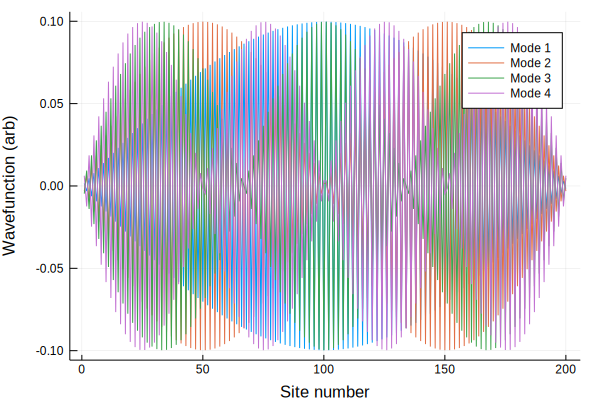

In [474]:
plot(1:N_el,[electron_1d.X[1:N_el],electron_1d.X[N_el+1:2*N_el],electron_1d.X[2*N_el+1:3*N_el],electron_1d.X[3*N_el+1:4*N_el]],xlabel = "Site number",ylabel = "Wavefunction (arb)",label=["Mode 1" "Mode 2" "Mode 3" "Mode 4"])

In [51]:
N_el = 4;
electron_1d = construct_matter(zeros(N_el),0.25*ev_hartree,5,N_el)

electronic(4, [0.0 0.00915369 0.0 0.0; 0.00915369 0.0 0.00915369 0.0; 0.0 0.00915369 0.0 0.00915369; 0.0 0.0 0.00915369 0.0], Complex{Float64}[0.0-0.0im 0.0-0.2im 0.0+0.0im 0.0+0.0im; 0.0-0.2im 0.0-0.0im 0.0-0.2im 0.0+0.0im; 0.0+0.0im 0.0-0.2im 0.0-0.0im 0.0-0.2im; 0.0+0.0im 0.0+0.0im 0.0-0.2im 0.0-0.0im], [0.371748; -0.601501; … ; 0.00565729; 0.014811])

## Data structures and routines to describe the photon 

In [23]:
struct photonic
    N::Int64 # spectral dimension 
    d::Int64 # polarization vector dimension
    freqs::Vector # frequencies of modes 1 to N    
    modes::Array # photonic modes in absence of matter. rows are now components, columns are mode #
end

# green's function of no positional arguments: you specify the bare modes "0" (see docs) at the
# position where you place the emitter. this is the one that will be used from now on. the two-position
# one may be useful down the line, so I won't remove it yet

# i,j denote components of the green's tensor now. set them appropriately

function green!(i,j,ω,P::photonic,G=0.0)
    # for now, positions pos1 and pos2 is going to be an integer index, which requires some input from the user
    # for lower dimensional cases where G will be 1 or 2 components, just set other components to zero. That works.
    spec_dim = P.N;
    for counter = 1:spec_dim
               G += conj(P.modes[i,counter])*(P.modes[j,counter])/((P.freqs[counter])^2-ω^2);
    end
    G = c^2*G;
    return G
end

function dgreen!(i,j,ω,P::photonic,dG=0.0)
    # for now, positions pos1 and pos2 is going to be an integer index, which requires some input from the user
    # for lower dimensional cases where G will be 1 or 2 components, just set other components to zero. That works.
    spec_dim = P.N;
    for counter = 1:spec_dim
               dG += -2*ω*conj(P.modes[i,counter])*(P.modes[j,counter])/((P.freqs[counter])^2-ω^2)^2;
    end
    dG = c^2*dG;
    return dG
end


function green2!(pos1,pos2,ω,P::photonic,G)
    # for now, positions pos1 and pos2 is going to be an integer index, which requires some input from the user
    # for lower dimensional cases where G will be 1 or 2 components, just set other components to zero. That works.
    spec_dim = P.N;
    space_dim = P.d;
    for counter = 1:spec_dim
        for ix = 1:space_dim
            for iy = 1:space_dim
               G[ix,iy] += conj(P.modes[pos1,counter,ix])*(P.modes[pos2,counter,iy])/((P.freqs[counter])^2-ω^2);
            end
        end
    end
    #G = c^2*G
    return G
end

function dgreen2!(pos1,pos2,ω,P::photonic,dG)
    # for now, positions pos1 and pos2 is going to be an integer index, which requires some input from the user
    # for lower dimensional cases where G will be 1 or 2 components, just set other components to zero. That works.
    spec_dim = P.N;
    space_dim = P.d;
    for counter = 1:spec_dim
        for ix = 1:space_dim
            for iy = 1:space_dim
               dG[ix,iy] += -2*ω*conj(P.modes[pos1,counter,ix])*(P.modes[pos2,counter,iy])/((P.freqs[counter])^2-ω^2)^2;
            end
        end
    end
    #G = c^2*G
    return dG
end

dgreen2! (generic function with 1 method)

#### Example of a photon: EM fields in a 1D cavity + its green's function in spectral representation

In [79]:
N_cav = 100;
d_cav = 1; # spatial dimension of the cavity mode, corresponds to number of vector components used to describe mode 
L_cav = 18904.0; # 1 micron in atomic units
S_cav = (10.0*nm)^2; #area of cavity

emitter_pos = L_cav/4; # position where the emitter is located

freqs_cav = pi*(1:N_cav)*c/L_cav;
modes_cav = zeros(d_cav,N_cav);
for counter = 1:N_cav
   modes_cav[1,counter] = sqrt(2.0/L_cav/S_cav)*sin(freqs_cav[counter]*emitter_pos/c); # for 2d or 3d, want two extra lines specifying those components 
end

pt_cav = photonic(N_cav,d_cav,freqs_cav,modes_cav)

photonic(100, 1, [0.0227676, 0.0455351, 0.0683027, 0.0910703, 0.113838, 0.136605, 0.159373, 0.182141, 0.204908, 0.227676  …  2.07185, 2.09462, 2.11738, 2.14015, 2.16292, 2.18569, 2.20845, 2.23122, 2.25399, 2.27676], [3.84742e-5 5.44107e-5 … 3.84742e-5 -2.67209e-20])

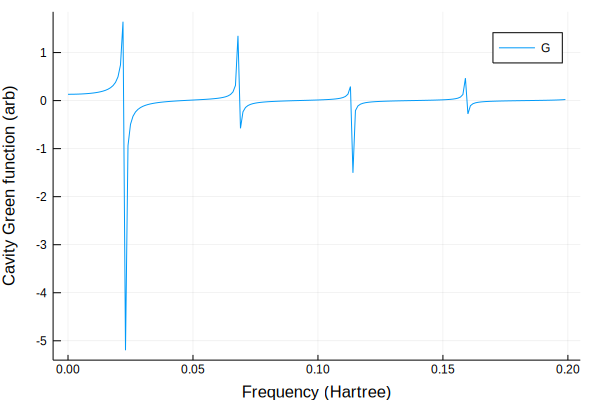

In [426]:
sample_ωs = 0:1e-3:2.5;
green_cav = [green!(1,1,ω,pt_cav) for ω in sample_ωs];
plot(sample_ωs[1:200],green_cav[1:200],xlabel = "Frequency (Hartree)",ylabel = "Cavity Green function (arb)",label=["G"])

#### A more involved example of a photon: EM fields in a 2D plasma + its green function in spectral representation

In [752]:
# This would be an example of user input.

# All of these parameters are used to specify the spectral properties of the plasma waves 

N_pl = 10000; # approximating a continuum of plasma waves 
d_pl = 3; # spatial dimension of the plasma wave, corresponds to number of vector components used to describe mode 
qmax_pl = 5.0/emitter_pos; # maximum spatial frequency of the plasma waves that I retain
β_pl = 1.0e10; # proportionality constant used to define the frequencies of the plasmons. SI units.
Nq_pl = 200; # sets number of spatial frequencies used to sample a continuum of spatial frequencies
Nθ_pl = 50; # sets number of propagation angles used to sample a continuum of propagation angles
qs_pl =  0:qmax_pl/Nq_pl:qmax_pl; #sets the spatial frequencies of the modes... what to do about angles??
θs_pl = 0:2*pi/Nθ_pl:2*pi; #sets their polar angle of propagation in the 2D plane
S_pl = (1.0/(qmax_pl/Nq_pl))^2;
ω_pl(q) = β_pl*sqrt(q/a0)*rads_ev*ev_hartree+1.0e-7;
index_pl(iq,iθ) = (Nθ_pl)*(iq-1) + iθ; 

# All of these parameters are used to specify the spectral properties of the plasma waves 

emitter_pos = 10*nm; # 10 nm away from the 2D plasma

# Creating all of the  

freqs_pl = zeros(N_pl);
modes_pl = zeros(Complex{Float64},d_pl,N_pl);

for iq = 1:Nq_pl
    q_tmp = qs_pl[iq];
    norm_tmp = sqrt(q_tmp/2.0/S_pl)*exp(-q_tmp*emitter_pos);
    for iθ = 1:Nθ_pl
       θ_tmp = θs_pl[iθ];
       counter = index_pl(iq,iθ)
       freqs_pl[counter] = ω_pl(q_tmp);
       modes_pl[:,counter] = norm_tmp*[cos(θ_tmp),sin(θ_tmp),im]; 
    end
end

pt_pl = photonic(N_pl,d_pl,freqs_pl,modes_pl)

photonic(10000, 3, [1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7  …  0.00537294, 0.00537294, 0.00537294, 0.00537294, 0.00537294, 0.00537294, 0.00537294, 0.00537294, 0.00537294, 0.00537294], Complex{Float64}[0.0+0.0im 0.0+0.0im … 1.01511e-7+0.0im 1.03977e-7+0.0im; 0.0+0.0im 0.0+0.0im … -2.60636e-8+0.0im -1.31354e-8+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+1.04804e-7im 0.0+1.04804e-7im])

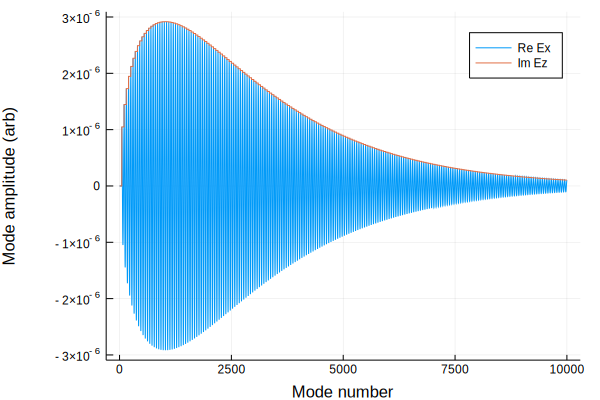

In [425]:
plot(1:10000,[real.(pt_pl.modes[1,:]),imag.(pt_pl.modes[3,:])],xlabel = "Mode number",ylabel = "Mode amplitude (arb)",label=["Re Ex" "Im Ez"]) 

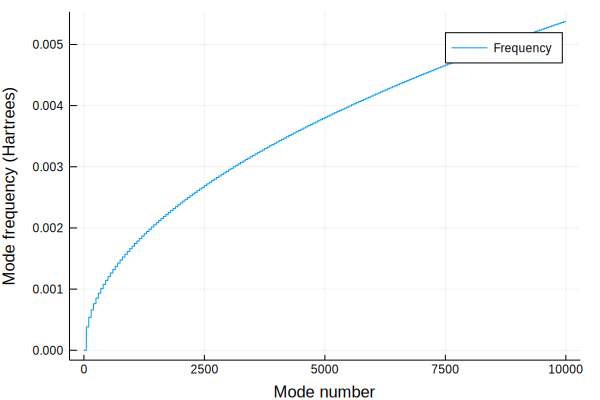

In [427]:
plot(1:10000,[real.(pt_pl.freqs)],xlabel = "Mode number",ylabel = "Mode frequency (Hartrees)",label=["Frequency"]) 

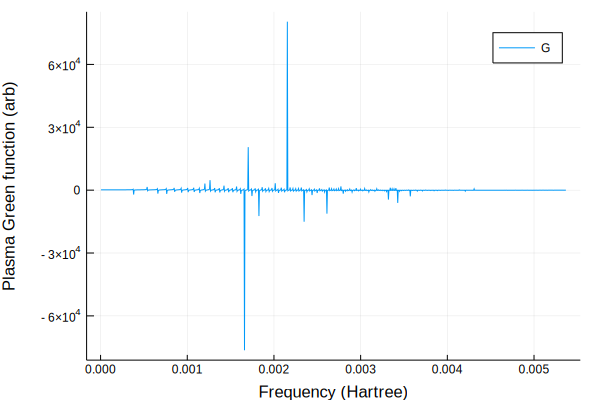

In [428]:
ωmax_pl = pt_pl.freqs[end]
N_sample = 1000.0;
sample_ωs = 0:ωmax_pl/N_sample:ωmax_pl;
green_pl = [real(green!(3,3,ω,pt_pl)) for ω in sample_ωs];
plot(sample_ωs,green_pl,xlabel = "Frequency (Hartree)",ylabel = "Plasma Green function (arb)",label=["G"])

There's an asymmetry here between the treatment of the matter and the photon: for the matter, I'm having functions that construct the electron class, while for the photon, the user needs to do it themselves. This is because for the matter, I'm working under a somewhat simplified model specified by a small number of parameters. While for the photon, I'm allowing the user to specify any photonic system they choose. 

## Routine for constructing nonlinear coupling terms in the equations

### For the "matter" equation

In [656]:
# for now keeping things one dimensional in p dot A = px*Ax

function scf_potential!(E::electronic,P::photonic,V_scf,str=1)
   
   N = E.N;
   H0 = E.H0;
   p = E.p;
   X = E.X; 
   
   spec_dim = P.N;
   vec_dim = P.d;
   
   for count_el = 1:N
        for count_pt = 1:spec_dim
           tmp_factor = (ħ/2/ϵ0/(P.freqs[count_pt]))*abs(P.modes[1,count_pt])^2/(X[N^2+1]-X[N^2+count_el]-P.freqs[count_pt]);
           V_scf += str*tmp_factor*p*(conj.(X[1+(count_el-1)*N:(count_el)*N]').*X[1+(count_el-1)*N:(count_el)*N])*p;
           V_scf = real.(V_scf); 
        end
   end

   return V_scf 
end

function scf_potential2!(X,E::electronic,P::photonic,V_scf,str=1)
   
   N = E.N;
   H0 = E.H0;
   p = E.p;
   # X = E.X; 
   
   spec_dim = P.N;
   vec_dim = P.d;
   
   for count_el = 1:N
        for count_pt = 1:spec_dim
           tmp_factor = (ħ/2/ϵ0/(P.freqs[count_pt]))*abs(P.modes[1,count_pt])^2/(X[N^2+1]-X[N^2+count_el]-P.freqs[count_pt]);
           V_scf += str*tmp_factor*p*(conj.(X[1+(count_el-1)*N:(count_el)*N]').*X[1+(count_el-1)*N:(count_el)*N])*p;
           V_scf = real.(V_scf); 
        end
   end

   return V_scf 
end

function scf_iter_eigs(E::electronic,P::photonic,V_scf,str)
   
   N = E.N;
   H0 = E.H0;
   p = E.p;
   X = E.X; 
   
   spec_dim = P.N;
   vec_dim = P.d;    
        
   V_scf = scf_potential!(E,P,V_scf,str);
   V_scf = (V_scf+V_scf')/2;
   H = H0 + V_scf;
   vecs_H,vals_H = eigvecs(H),eigvals(H);
   tmp1 = reshape(vecs_H,(N^2,1));
   tmp2 = reshape(vals_H,(N,1));
   X = [tmp1
        tmp2];
    
   electron = electronic(N,H0,p,X)
        
 return electron
end

function scf_iter_eigs2(X,E::electronic,P::photonic,V_scf,str)
   
   N = E.N;
   H0 = E.H0;
   p = E.p;
  # X = E.X; 
   
   spec_dim = P.N;
   vec_dim = P.d;    
        
   V_scf = scf_potential2!(X,E,P,V_scf,str);
   V_scf = (V_scf+V_scf')/2;
   H = H0 + V_scf;
   vecs_H,vals_H = eigvecs(H),eigvals(H);
   tmp1 = reshape(vecs_H,(N^2,1));
   tmp2 = reshape(vals_H,(N,1));
   X = [tmp1
        tmp2];
    
  # electron = electronic(N,H0,p,X)
        
 return X
end

scf_iter_eigs2 (generic function with 1 method)

### For the "photon" equation

In [171]:
function photon_potential_A2(str)
   
   λ = str*qe^2/me/ϵ0/c^2;
    
   return λ 
end

photon_potential_A2 (generic function with 1 method)

## Routines to solve the nonlinear equations separately (no self-consistency)

#### For the photon

In [267]:
function f_pt!(F,λ)#,str=1)
  #  weight = photon_potential_A2(str);
    F[1] = -weight*green!(1,1,λ[1],pt_cav,0.0)[1] - 1
end

function j_pt!(J,λ)#,str=1)
  #  weight = photon_potential_A2(str);
    J[1] = weight*dgreen!(1,1,λ[1],pt_cav,0.0)[1] 
end

j_pt! (generic function with 2 methods)

In [343]:
# "int" denotes interacting or coupled

function construct_coupled_freqs(P::photonic,weight)
    N = P.N;
    freqs_int = zeros(N,1)
    
    for count = 1:N
        if abs(P.modes[count])^2 >= (1.0e-2)*abs(P.modes[1])^2
        sol_pt = nlsolve(f_pt!,[(count+0.02)*pi*c/L_cav])
        freqs_int[count] = sol_pt.zero[1];
        else
        freqs_int[count] = P.freqs[count]
        end
    end
    
    freqs_int = reshape(freqs_int,(N));
    freqs_int = sort(freqs_int);
    
 return freqs_int
end

construct_coupled_freqs (generic function with 1 method)

#### For the electron

In [738]:
# Using only the eigenvalues to assess convergence.

function f_el!(F,X)
    el =  scf_iter_eigs(E,P,zeros(N_el,N_el),str);
   #print("$(E)");
    N = el.N;
    X = el.X;
    print("$(real(X[end-N+1:end])) \n")
    for count = 1:N
        F[count] = X[end-N+count] 
    end
end

function f_el2!(F,X)
    X =  scf_iter_eigs2(X,E,P,zeros(N_el,N_el),str);
   # print("$(X)")
    N = E.N;
    print("$(real(X[end-N+1:end])) \n")
    for count = 1:size(X,1)
        F[count] = X[count];#X[end-N+count] 
    end

end

# function mode(freq)
#    fieldmode = zeros(num_positions_cav);
#    for position = 1:num_positions_cav
#        fieldmode[position] = green!(position,501,freq,pt_cav,[0.0])[1]; 
#    end    
#    fieldmode = fieldmode / norm(fieldmode);
#   return fieldmode 
# end

## Demo

Step 1: Construct your electron and photon. Note: the entry below is identical to test lines earlier in the notebook, so feel free to skip everything and start here.

In [478]:
N_el = 4;
electron_1d = construct_matter(zeros(N_el),0.25*ev_hartree,5,N_el)

electronic(4, [0.0 0.00915369 0.0 0.0; 0.00915369 0.0 0.00915369 0.0; 0.0 0.00915369 0.0 0.00915369; 0.0 0.0 0.00915369 0.0], Complex{Float64}[0.0-0.0im 0.0-0.2im 0.0+0.0im 0.0+0.0im; 0.0-0.2im 0.0-0.0im 0.0-0.2im 0.0+0.0im; 0.0+0.0im 0.0-0.2im 0.0-0.0im 0.0-0.2im; 0.0+0.0im 0.0+0.0im 0.0-0.2im 0.0-0.0im], [0.371748; -0.601501; … ; 0.00565729; 0.014811])

In [479]:
N_cav = 100;
d_cav = 1; # spatial dimension of the cavity mode, corresponds to number of vector components used to describe mode 
L_cav = 18904.0; # 1 micron in atomic units
S_cav = (10.0*nm)^2; #area of cavity

emitter_pos = L_cav/2; # position where the emitter is located

freqs_cav = pi*(1:N_cav)*c/L_cav;
modes_cav = zeros(d_cav,N_cav);
for counter = 1:N_cav
   modes_cav[1,counter] = sqrt(2.0/L_cav/S_cav)*sin(freqs_cav[counter]*emitter_pos/c); # for 2d or 3d, want two extra lines specifying those components 
end

pt_cav = photonic(N_cav,d_cav,freqs_cav,modes_cav)

photonic(100, 1, [0.0227676, 0.0455351, 0.0683027, 0.0910703, 0.113838, 0.136605, 0.159373, 0.182141, 0.204908, 0.227676  …  2.07185, 2.09462, 2.11738, 2.14015, 2.16292, 2.18569, 2.20845, 2.23122, 2.25399, 2.27676], [5.44107e-5 6.66339e-21 … -5.44107e-5 5.34418e-20])

Step 2a: Solve the equation for the photon

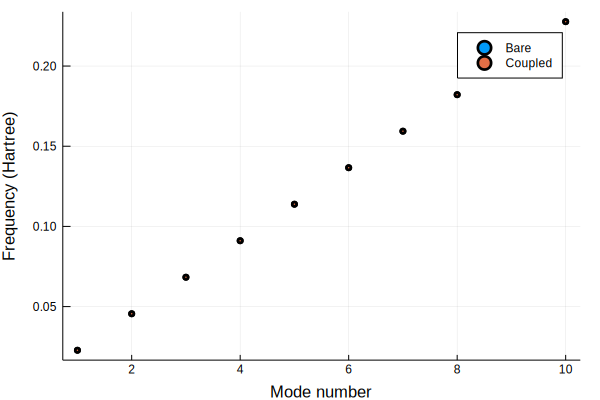

In [480]:
weight = 1*qe^2/me/ϵ0/c^2;
freqs_int = construct_coupled_freqs(pt_cav,weight);
plot(1:10,[pt_cav.freqs[1:10],freqs_int[1:10]],xlabel = "Mode number",ylabel = "Frequency (Hartree)",line=false,marker=true,markersize=2,markeralpha=1,markerstrokewidth=3,label=["Bare" "Coupled"])

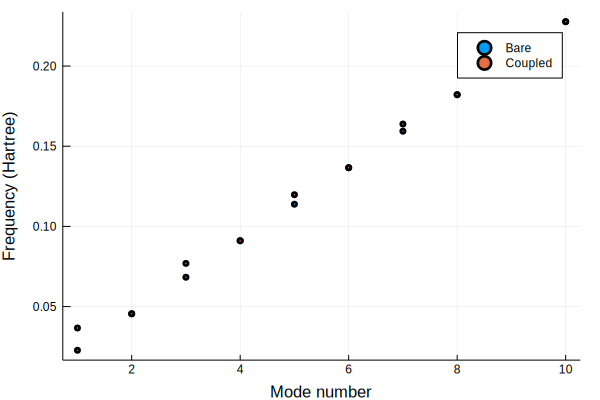

In [481]:
weight = 40000*qe^2/me/ϵ0/c^2;
freqs_int = construct_coupled_freqs(pt_cav,weight);
plot(1:10,[pt_cav.freqs[1:10],freqs_int[1:10]],xlabel = "Mode number",ylabel = "Frequency (Hartree)",line=false,marker=true,markersize=2,markeralpha=1,markerstrokewidth=3,label=["Bare" "Coupled"])

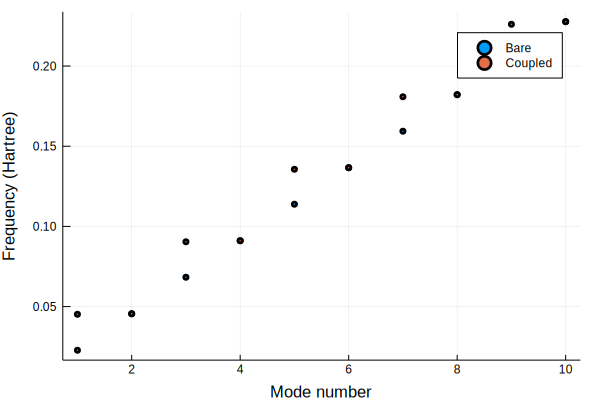

In [482]:
weight = 1000000*qe^2/me/ϵ0/c^2;
freqs_int = construct_coupled_freqs(pt_cav,weight);
plot(1:10,[pt_cav.freqs[1:10],freqs_int[1:10]],xlabel = "Mode number",ylabel = "Frequency (Hartree)",line=false,marker=true,markersize=2,markeralpha=1,markerstrokewidth=3,label=["Bare" "Coupled"])

Step 2b: Solve the equation for the electron. (I'm not sure this is converged yet).

#### Electron coupled to a photon in a 1D cavity

In [741]:
E = electron_1d;
X0 = E.X
P = pt_cav;
str = 10000;

In [742]:
sol_el= fixedpoint(f_el2!, X0; method = :anderson, m=0,beta=1.0,iterations=1500)

[-0.000595386, 0.00959421, 0.0313629, 0.0378742] 
[0.00107939, 0.00744818, 0.010586, 0.0351307] 
[0.00107939, 0.0106729, 0.0226441, 0.036402] 
[0.00107939, 0.0106616, 0.011624, 0.0360179] 
[0.00107939, 0.0106631, 0.01867, 0.0361323] 
[0.00107939, 0.0106629, 0.0137465, 0.0360981] 
[0.00107939, 0.0106629, 0.0169925, 0.0361083] 
[0.00107939, 0.0106629, 0.014765, 0.0361052] 
[0.00107939, 0.0106629, 0.0162533, 0.0361062] 
[0.00107939, 0.0106629, 0.0152406, 0.0361059] 
[0.00107939, 0.0106629, 0.0159213, 0.036106] 
[0.00107939, 0.0106629, 0.0154599, 0.0361059] 
[0.00107939, 0.0106629, 0.0157709, 0.0361059] 
[0.00107939, 0.0106629, 0.0155605, 0.0361059] 
[0.00107939, 0.0106629, 0.0157025, 0.0361059] 
[0.00107939, 0.0106629, 0.0156065, 0.0361059] 
[0.00107939, 0.0106629, 0.0156713, 0.0361059] 
[0.00107939, 0.0106629, 0.0156275, 0.0361059] 
[0.00107939, 0.0106629, 0.0156571, 0.0361059] 
[0.00107939, 0.0106629, 0.0156371, 0.0361059] 
[0.00107939, 0.0106629, 0.0156506, 0.0361059] 
[0.00107939, 0.0

Results of Nonlinear Solver Algorithm
 * Algorithm: Anderson m=0 beta=1.0
 * Starting Point: [0.371748; -0.601501; 0.601501; -0.371748; 0.601501; -0.371748; -0.371748; 0.601501; 0.601501; 0.371748; -0.371748; -0.601501; 0.371748; 0.601501; 0.601501; 0.371748; -0.014811; -0.00565729; 0.00565729; 0.014811]
 * Zero: [0.601501; -0.371748; -0.371748; 0.601501; -0.601501; -0.371748; 0.371748; 0.601501; -0.371748; 0.601501; -0.601501; 0.371748; -0.371748; -0.601501; -0.601501; -0.371748; 0.00107939; 0.0106629; 0.0156452; 0.0361059]
 * Inf-norm of residuals: 0.000000
 * Iterations: 42
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 42
 * Jacobian Calls (df/dx): 0

#### A case with a plasmon: note the effect of anderson acceleration here! It makes the result nearly converge.

In [754]:
E = electron_1d;
X0 = E.X
P = pt_pl;
str = 10000;

In [755]:
pt_pl

photonic(10000, 3, [1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7, 1.0e-7  …  0.00537294, 0.00537294, 0.00537294, 0.00537294, 0.00537294, 0.00537294, 0.00537294, 0.00537294, 0.00537294, 0.00537294], Complex{Float64}[0.0+0.0im 0.0+0.0im … 1.01511e-7+0.0im 1.03977e-7+0.0im; 0.0+0.0im 0.0+0.0im … -2.60636e-8+0.0im -1.31354e-8+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+1.04804e-7im 0.0+1.04804e-7im])

In [765]:
sol_el= fixedpoint(f_el2!, X0; method = :anderson, m=0,beta=1.0,iterations=200)

[0.263185, 0.516884, 1.26699, 25.5569] 
[-0.0132503, 0.0168752, 0.0540643, 3.73652] 
[0.00719255, 0.174159, 0.585049, 25.5569] 
[-0.0132659, 0.0284468, 0.0829028, 3.73652] 
[0.00719254, 0.126376, 0.417289, 25.5569] 
[-0.0132659, 0.0419037, 0.110627, 3.73652] 
[0.00719254, 0.0952427, 0.328594, 25.5569] 
[-0.0132659, 0.0583626, 0.136912, 3.73652] 
[0.00719254, 0.0726586, 0.274367, 25.5569] 
[-0.0132659, 0.0798219, 0.161517, 3.73652] 
[0.00719254, 0.0549678, 0.238224, 25.5569] 
[-0.0132659, 0.110262, 0.184279, 3.73652] 
[0.00719254, 0.0402565, 0.21273, 25.5569] 
[-0.0132659, 0.159042, 0.205105, 3.73652] 
[0.00719254, 0.0274013, 0.194019, 25.5569] 
[-0.0132659, 0.223969, 0.254897, 3.73652] 
[0.00719254, 0.0156685, 0.179883, 25.5569] 
[-0.0132659, 0.240902, 0.551314, 3.73652] 
[0.00451, 0.00719254, 0.168968, 25.5569] 
[-0.0132661, 0.252089, 1.29346, 3.7252] 
[-0.00411739, 0.0100586, 0.162516, 25.5569] 
[-0.0132666, 0.249026, 0.364243, 3.7252] 
[-0.0041174, 0.0208373, 0.164228, 25.5569] 
[-0

[-0.0041174, 0.0569484, 0.170356, 25.5569] 
[-0.0132666, 0.0971095, 0.238617, 3.7252] 
[-0.0041174, 0.0569484, 0.170356, 25.5569] 
[-0.0132666, 0.0971095, 0.238617, 3.7252] 
[-0.0041174, 0.0569484, 0.170356, 25.5569] 
[-0.0132666, 0.0971095, 0.238617, 3.7252] 
[-0.0041174, 0.0569484, 0.170356, 25.5569] 
[-0.0132666, 0.0971095, 0.238617, 3.7252] 
[-0.0041174, 0.0569484, 0.170356, 25.5569] 
[-0.0132666, 0.0971095, 0.238617, 3.7252] 


Results of Nonlinear Solver Algorithm
 * Algorithm: Anderson m=0 beta=1.0
 * Starting Point: [0.371748; -0.601501; 0.601501; -0.371748; 0.601501; -0.371748; -0.371748; 0.601501; 0.601501; 0.371748; -0.371748; -0.601501; 0.371748; 0.601501; 0.601501; 0.371748; -0.014811; -0.00565729; 0.00565729; 0.014811]
 * Zero: [0.371748; -0.601501; 0.601501; -0.371748; -0.601501; -0.371748; 0.371748; 0.601501; 0.371748; 0.601501; 0.601501; 0.371748; 0.601501; -0.371748; -0.371748; 0.601501; -0.0132666; 0.0971095; 0.238617; 3.7252]
 * Inf-norm of residuals: 21.831679
 * Iterations: 200
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: false
 * Function Calls (f): 200
 * Jacobian Calls (df/dx): 0

In [764]:
sol_el= fixedpoint(f_el2!, X0; method = :anderson, m=4,beta=0.4,iterations=200)

[0.263185, 0.516884, 1.26699, 25.5569] 
[0.00615514, 0.0343808, 0.0472375, 9.79007] 
[0.000621614, 0.0105159, 0.110725, 7.09323] 
[0.00231413, 0.0169815, 0.128549, 2.41656] 
[0.00613677, 0.0316546, 0.109467, 0.953736] 
[0.000553108, 0.0327483, 0.150303, 1.30889] 
[-0.00177268, 0.0280488, 0.184916, 5.25359] 
[-0.00683997, 0.0467285, 0.220932, 3.4556] 
[-0.00571096, 0.0521267, 0.240041, 3.63688] 
[0.0055887, 0.0700533, 0.290675, 5.92125] 
[0.00522135, 0.0568525, 0.29885, 8.97965] 
[0.00445556, 0.0465877, 0.272113, 4.82807] 
[0.00403178, 0.0606943, 0.335931, 6.45924] 
[0.00243579, 0.0518695, 0.317484, 8.49679] 
[0.00136235, 0.0502723, 0.301026, 8.20241] 
[0.00163123, 0.0501846, 0.301218, 8.98893] 
[0.00160478, 0.0506863, 0.30387, 9.05138] 
[0.00161389, 0.0506482, 0.303096, 9.061] 
[0.00161497, 0.050506, 0.303144, 9.06027] 
[0.00165849, 0.0508875, 0.30216, 8.98198] 
[0.00165719, 0.0505946, 0.301563, 8.92663] 
[0.001626, 0.0495954, 0.306053, 9.03466] 
[0.0016496, 0.0503352, 0.306663, 8.9338

[0.00154379, 0.07471, 0.205931, 9.5388] 
[0.00154381, 0.0748311, 0.205553, 9.54501] 
[0.00154376, 0.0746735, 0.206027, 9.53671] 
[0.00154375, 0.0748556, 0.205479, 9.54553] 
[0.00154374, 0.0747523, 0.205791, 9.5398] 
[0.00154374, 0.0747692, 0.205723, 9.54082] 
[0.00154377, 0.074715, 0.20593, 9.53864] 
[0.00154375, 0.0747345, 0.205866, 9.53907] 
[0.00154374, 0.0747214, 0.205942, 9.53808] 
[0.00154375, 0.0747583, 0.205767, 9.54104] 
[0.00154377, 0.0747969, 0.205597, 9.5442] 
[0.0015439, 0.0749636, 0.204878, 9.55976] 


Results of Nonlinear Solver Algorithm
 * Algorithm: Anderson m=4 beta=0.4
 * Starting Point: [0.371748; -0.601501; 0.601501; -0.371748; 0.601501; -0.371748; -0.371748; 0.601501; 0.601501; 0.371748; -0.371748; -0.601501; 0.371748; 0.601501; 0.601501; 0.371748; -0.014811; -0.00565729; 0.00565729; 0.014811]
 * Zero: [-0.18954; -0.647709; 0.592523; 0.439838; 0.615481; -0.167559; -0.449817; 0.624658; -0.397552; -0.620909; -0.634178; -0.231512; -0.653282; 0.408085; -0.209899; 0.602168; 0.0015438; 0.0746663; 0.206053; 9.53881]
 * Inf-norm of residuals: 0.000254
 * Iterations: 200
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: false
 * Function Calls (f): 200
 * Jacobian Calls (df/dx): 0